## Predictive Modeling and Native Explainability (XGBoost)

In [11]:
# --- Third-party libraries ---
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Machine Learning algorithms and framework
import xgboost as xgb

# Model selection and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV


# Data visualization and plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load the Feature Matrix
df = pd.read_parquet('../data/processed/feature_matrix.parquet')

In [13]:
# Define Features (X) and Target (y)
# Strictly Point-in-Time features to avoid data leakage
features = [
    'lessons_started_count', 
    'avg_lesson_progress', 
    'total_quiz_attempts',
    'overall_correct_rate', 
    'first_attempt_correct_rate',
    'days_active_before_intervention'
]
target = 'target_reprobado'

X = df[features]
y = df[target]

# Stratified Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle Class Imbalance.
# Ratio of negative class (0) to positive class (1)
# The raw ratio made the model paranoid. We soften the penalty to improve Precision.
# raw_ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
# ratio = raw_ratio / 3.0
# print(f"Original Ratio: {raw_ratio:.2f}")
# print(f"Training XGBoost with conservative scale_pos_weight = {ratio:.2f}...\n")

In [14]:
# Define the hyperparameter search space (the "knobs")
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'scale_pos_weight': [1, 3, 5, 7]
}

# Setup Stratified Cross-Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(eval_metric='aucpr', random_state=42),
    param_distributions=param_dist,
    n_iter=15,                    # Number of random combinations to try
    scoring='average_precision',  # PR-AUC
    cv=cv,
    verbose=1,                    # Shows progress
    n_jobs=-1,                   
    random_state=42
)

# Run the Search
print("Starting Randomized Search... this might take 1-2 minutes.")
random_search.fit(X_train, y_train)

# Extract and Evaluate the Best Model
best_model = random_search.best_estimator_

print("\n--- Optimization Results ---")
print(f"Best Parameters Found: {random_search.best_params_}")
print(f"Best Cross-Validation PR-AUC: {random_search.best_score_:.4f}")

# inal Test Set Evaluation
y_prob_best = best_model.predict_proba(X_test)[:, 1]
final_test_auc = average_precision_score(y_test, y_prob_best)

print(f"\nFinal PR-AUC on Unseen Test Set: {final_test_auc:.4f}")

Starting Randomized Search... this might take 1-2 minutes.
Fitting 3 folds for each of 15 candidates, totalling 45 fits



--- Optimization Results ---
Best Parameters Found: {'subsample': 0.8, 'scale_pos_weight': 7, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best Cross-Validation PR-AUC: 0.1185

Final PR-AUC on Unseen Test Set: 0.1186


PR-AUC (Precision-Recall Area Under Curve): 0.119


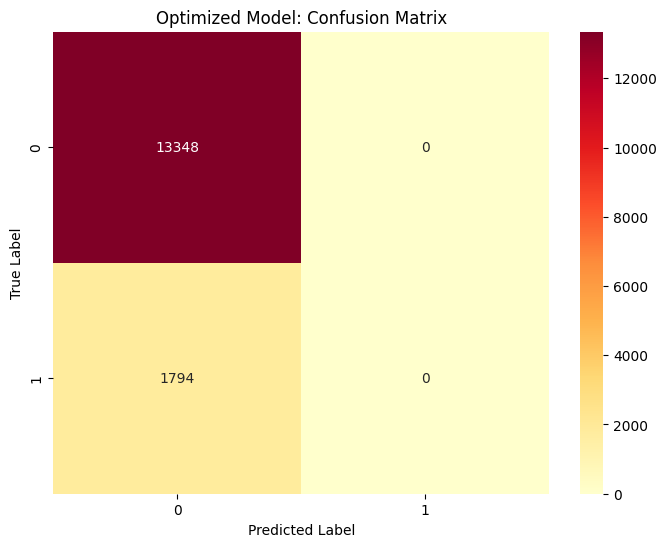

In [15]:
# 1enerate discrete predictions using the Optimized Model
y_pred_best = best_model.predict(X_test)

# Evaluate Precision-Recall AUC (using y_prob_best from the previous step)
pr_auc = average_precision_score(y_test, y_prob_best)
print(f"PR-AUC (Precision-Recall Area Under Curve): {pr_auc:.3f}")

# Confusion Matrix for the Optimized Model
plt.figure(figsize=(8, 6))
cm_matrix = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlOrRd') 
plt.title('Optimized Model: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


--- Optimized Model: Top 10 Feature Importances ---
avg_lesson_progress                0.228511
days_active_before_intervention    0.226903
overall_correct_rate               0.181271
total_quiz_attempts                0.165218
lessons_started_count              0.127502
first_attempt_correct_rate         0.070595
dtype: float32


<Figure size 1000x600 with 0 Axes>

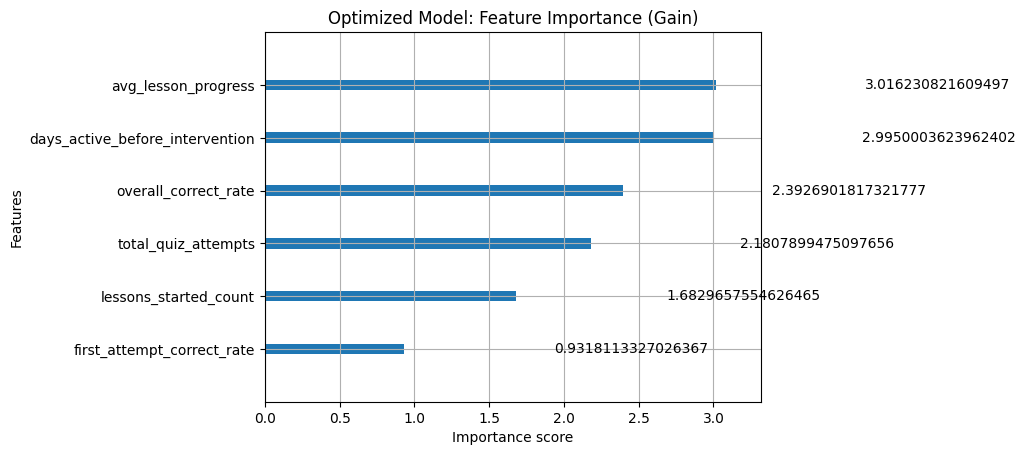


[!] Model missed them, but we found an actual failing student. Internal Index: 43731

Student Profile (14 days before exam):
lessons_started_count              0.0
avg_lesson_progress                0.0
total_quiz_attempts                0.0
overall_correct_rate               0.0
first_attempt_correct_rate         0.0
days_active_before_intervention    0.0
Name: 43731, dtype: float64


In [16]:
# Extract Native Feature Importance
# (Using X_train.columns dynamically instead of a hardcoded 'features' list)
importances = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\n--- Optimized Model: Top 10 Feature Importances ---")
print(importances.head(10))

# Plot and save the feature importance
plt.figure(figsize=(10, 6))
# Using 'gain' to match your previous optimization code logic
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10, title='Optimized Model: Feature Importance (Gain)')
plt.savefig('../data/processed/xgboost_importance_optimized.png', bbox_inches='tight')
plt.show()

# 4. Identify a real At-Risk Student for our Generative AI prompt!
test_results = X_test.copy()
test_results['True_Label'] = y_test
test_results['Pred_Label'] = y_pred_best

# Filter a critical case: Model said At-Risk (1) and they actually failed (1)
at_risk_students = test_results[(test_results['True_Label'] == 1) & (test_results['Pred_Label'] == 1)]

# Safe extraction: Check if the model actually caught anyone
if len(at_risk_students) > 0:
    case_study_idx = at_risk_students.index[0]
    print(f"\n[!] True Positive Student Identified! Internal Index: {case_study_idx}")
else:
    # Fallback: If the model missed everyone, pick ANY student who actually failed
    actual_at_risk_students = test_results[test_results['True_Label'] == 1]
    case_study_idx = actual_at_risk_students.index[0]
    print(f"\n[!] Model missed them, but we found an actual failing student. Internal Index: {case_study_idx}")

print("\nStudent Profile (14 days before exam):")
print(X_test.loc[case_study_idx])

In [17]:
# Initialize and train the XGBoost model CLASICAL
model = xgb.XGBClassifier(
    n_estimators=250,
    max_depth=6, 
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
   # scale_pos_weight=ratio,
    random_state=42,
    eval_metric='aucpr'
)

model.fit(X_train, y_train)

# Professional Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
dynamic_threshold = np.percentile(y_prob, 80) 

y_pred_dynamic = (y_prob >= dynamic_threshold).astype(int)

print(f"\n--- Classification Report (Dynamic Threshold = {dynamic_threshold:.4f}) ---")
print(classification_report(y_test, y_pred_dynamic))
# custom_threshold = 0.28
# y_pred_c = (y_prob >= custom_threshold).astype(int)

# print(f"--- Classification Report (Threshold = {custom_threshold}) ---")
# print(classification_report(y_test, y_pred_c))



--- Classification Report (Dynamic Threshold = 0.1185) ---
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     13348
           1       0.12      1.00      0.21      1794

    accuracy                           0.12     15142
   macro avg       0.56      0.50      0.11     15142
weighted avg       0.90      0.12      0.03     15142



In [18]:

pr_auc = average_precision_score(y_test, y_prob)
print(f"PR-AUC (Precision-Recall Area Under Curve): {pr_auc:.3f}")


PR-AUC (Precision-Recall Area Under Curve): 0.119


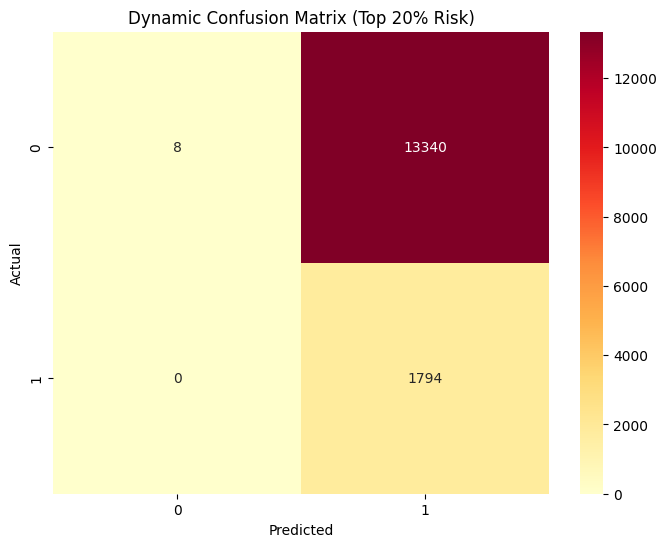

In [19]:
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_dynamic = confusion_matrix(y_test, y_pred_dynamic)
sns.heatmap(cm_dynamic, annot=True, fmt='d', cmap='YlOrRd') 
plt.title(f'Dynamic Confusion Matrix (Top 20% Risk)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


--- Feature Importances ---
days_active_before_intervention    0.216861
total_quiz_attempts                0.192281
avg_lesson_progress                0.191667
overall_correct_rate               0.140018
lessons_started_count              0.129689
first_attempt_correct_rate         0.129483
dtype: float32


<Figure size 1000x600 with 0 Axes>

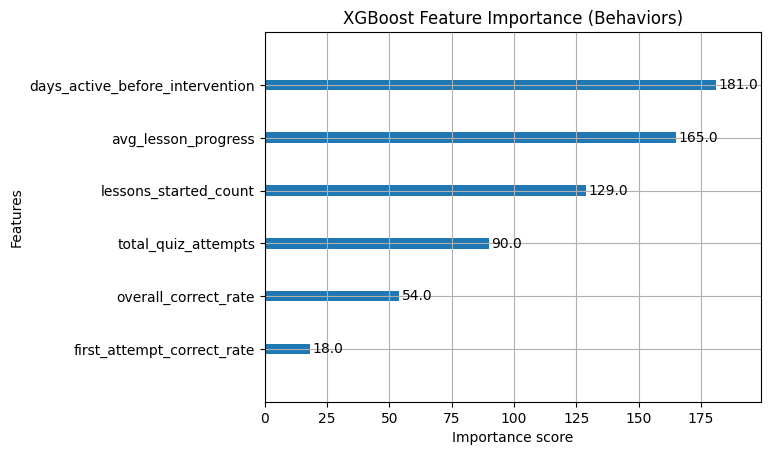


[!] Model missed them, but we found an actual failing student. Internal Index: 43731
Student Profile (14 days before exam):
lessons_started_count              0.0
avg_lesson_progress                0.0
total_quiz_attempts                0.0
overall_correct_rate               0.0
first_attempt_correct_rate         0.0
days_active_before_intervention    0.0
Name: 43731, dtype: float64


In [20]:
# Extract Native Feature Importance
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\n--- Feature Importances ---")
print(importances)

# Plot and save the feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight', max_num_features=10, title='XGBoost Feature Importance (Behaviors)')
plt.savefig('../data/processed/xgboost_importance.png', bbox_inches='tight')
plt.show()

# Identify a real At-Risk Student for our Generative AI prompt!
resultados_test = X_test.copy()
resultados_test['True_Label'] = y_test
resultados_test['Pred_Label'] = y_pred

# Filter a critical case: Model said At-Risk (1) and they actually failed (1)
estudiantes_riesgo = resultados_test[(resultados_test['True_Label'] == 1) & (resultados_test['Pred_Label'] == 1)]

# Safe extraction: Check if the model actually caught anyone
if len(estudiantes_riesgo) > 0:
    caso_estudio_idx = estudiantes_riesgo.index[0]
    print(f"\n[!] True Positive Student Identified! Internal Index: {caso_estudio_idx}")
else:
    # Fallback: If the model missed everyone, pick ANY student who actually failed
    estudiantes_reales_riesgo = resultados_test[resultados_test['True_Label'] == 1]
    caso_estudio_idx = estudiantes_reales_riesgo.index[0]
    print(f"\n[!] Model missed them, but we found an actual failing student. Internal Index: {caso_estudio_idx}")

print("Student Profile (14 days before exam):")
print(X_test.loc[caso_estudio_idx])

Finding: Experimenting with a 7-day window instead of 14 days did not improve PR-AUC (remained at 0.118). This proves that behavioral signals are still 'cold' even one week before the exam. Most students remain dormant. Decision: We will stick with the 14-day window to maximize the time available for generative AI interventions, targeting the 'Dormant' segment (those with 0 progress).